# Learning from CFGs

In [1]:
# Preamble.
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
import time
import humanize

from labm8 import viz

from experimental.compilers.reachability import reachability_pb2
from experimental.compilers.reachability import control_flow_graph as cfg
from experimental.compilers.reachability import control_flow_graph_generator as cfg_generator
from experimental.compilers.reachability import cfg_datasets as datasets

%matplotlib inline

In [2]:
# Plotting utils.

def GetName(g, n, label_entry_and_exit = True) -> str:
    if label_entry_and_exit:
        if g.nodes[n].get('entry', False):
            return 'Entry'
        if g.nodes[n].get('exit', False):
            return 'Exit'
    return g.nodes[n]['name']
    
def DrawGraph(g: cfg.ControlFlowGraph, ax=None, label_entry_and_exit = True) -> None:
    ax = ax or plt.gca()
    nx.draw_spring(g, labels={n: GetName(g, n, label_entry_and_exit) for n in g.nodes}, node_size=600)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

## Generating Random CFGs

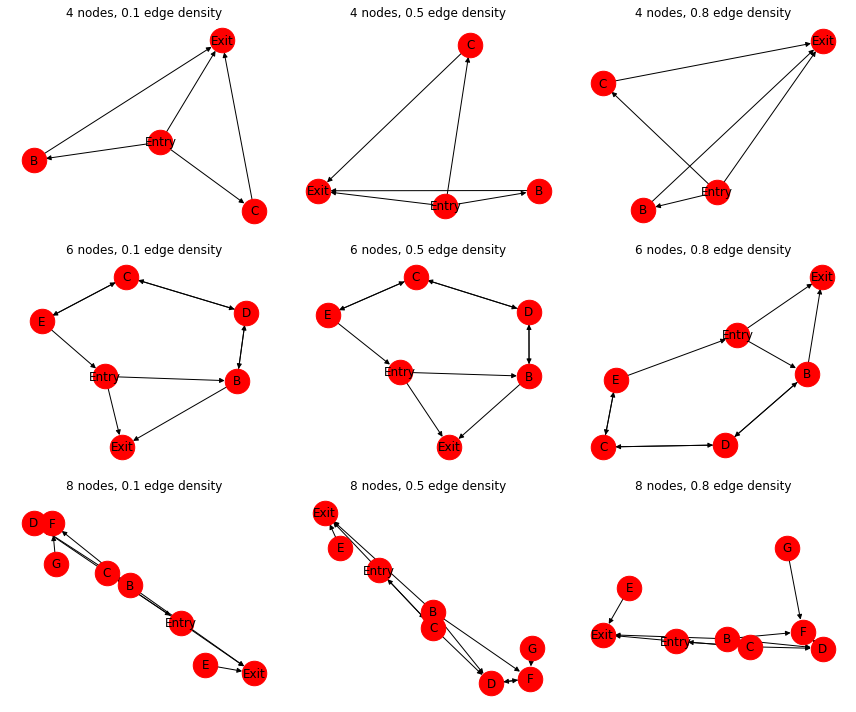

In [3]:
# Parameter sweep to draw a grid of basic blocks.
num_nodes = [4, 6, 8]
edge_densities = [0.1, 0.5, 0.8]

fig = plt.figure(figsize=(int(4 * len(edge_densities)), int(3.5 * len(num_nodes))))
fig.clf()

for j, n in enumerate(num_nodes):
    for i, ed in enumerate(edge_densities):
        ax_index = (j * len(edge_densities)) + i + 1
        ax = fig.add_subplot(len(num_nodes), len(edge_densities), ax_index)
        # Generate a graph with the requested num blocks and edge density. Use the
        # same random seed per row.
        graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(j), (n, n), ed))
        DrawGraph(graph, ax=ax)
        ax.set_title(f'{n} nodes, {ed} edge density')

viz.finalise()

### CFG Reachabilities

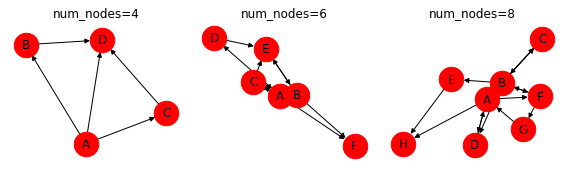

A  B  C  D  E  F  G  H
num_nodes src                        
4         A    ✘  ✓  ✓  ✓            
          B    ✘  ✘  ✘  ✓            
          C    ✘  ✘  ✘  ✓            
          D    ✘  ✘  ✘  ✘            
6         A    ✘  ✓  ✓  ✓  ✓  ✓      
          B    ✓  ✘  ✓  ✓  ✓  ✓      
          C    ✓  ✓  ✘  ✓  ✓  ✓      
          D    ✓  ✓  ✓  ✘  ✓  ✓      
          E    ✓  ✓  ✓  ✓  ✘  ✓      
          F    ✘  ✘  ✘  ✘  ✘  ✘      
8         A    ✘  ✓  ✓  ✓  ✓  ✓  ✓  ✓
          B    ✓  ✘  ✓  ✓  ✓  ✓  ✓  ✓
          C    ✓  ✓  ✘  ✓  ✓  ✓  ✓  ✓
          D    ✓  ✓  ✓  ✘  ✓  ✓  ✓  ✓
          E    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✓
          F    ✓  ✓  ✓  ✓  ✓  ✘  ✓  ✓
          G    ✓  ✓  ✓  ✓  ✓  ✓  ✘  ✓
          H    ✘  ✘  ✘  ✘  ✘  ✘  ✘  ✘

In [4]:
def BinArray(array):
    return ['✓' if x else '✘' for x in array]

fig = plt.figure(figsize=(8, 2.5))
fig.clf()

num_nodes = [4, 6, 8]

g = cfg_generator.UniqueNameSequence('A')
node_names = [g for g, _ in zip(g, range(max(num_nodes)))]
edge_density = 0.01
rows = []
for i, n in enumerate(num_nodes):
    graph = next(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(0), (n, n), edge_density))
    ax = fig.add_subplot(1, 3, i + 1)
    DrawGraph(graph, ax=ax, label_entry_and_exit=False)
    ax.set_title(f'num_nodes={n}')
    for node in graph.nodes:
        rows.append([graph.number_of_nodes(), node_names[node]] + 
                    BinArray(graph.Reachables(node)) + 
                    [''] * (max(num_nodes) - len(graph.nodes)))

viz.finalise()
df = pd.DataFrame(rows, columns = ['num_nodes', 'src'] + node_names)
df.set_index(['num_nodes', 'src'], inplace=True)
df

### Proportion of Basic Blocks that are Reachable

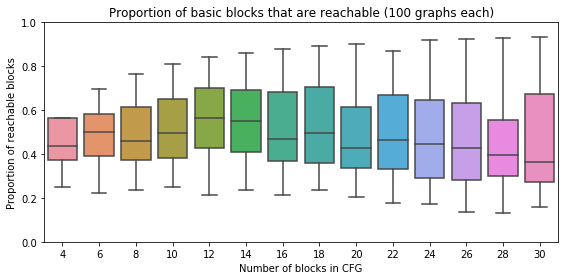

In [5]:
num_nodes = list(range(4, 31, 2))
edge_density = 0.1
num_graphs = 100

rows = []
for i, n in enumerate(num_nodes):
    generator = cfg_generator.ControlFlowGraphGenerator(
        np.random.RandomState(0), (n, n), edge_density)
    graphs = generator.Generate(num_graphs)
    for graph in graphs:
        num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
        rows.append((n, num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

sns.boxplot(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of blocks in CFG')
plt.ylabel('Proportion of reachable blocks')
plt.title(f'Proportion of basic blocks that are reachable ({num_graphs} graphs each)')
plt.ylim((0, 1))
viz.finalise(figsize=(8, 4))

## OpenCL Dataset

In [7]:
ocl_dataset = datasets.OpenClDeviceMappingsDataset()

ocl_dataset_graphs = ocl_dataset.cfgs_df['cfg:graph'].values

print(ocl_dataset.cfgs_df.shape)
ocl_dataset.cfgs_df.head(10)

(191, 5)


cfg:graph  \
program:benchmark_suite_name program:benchmark_name program:opencl_kernel_name                                                           
amd-app-sdk-3.0              BinomialOption         binomial_options                                    (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   
                             FloydWarshall          floydWarshallPass                                                        (0, 1, 2)   
                             MatrixMultiplication   mmmKernel                                                          (0, 1, 2, 3, 4)   
                             PrefixSum              group_prefixSum                  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
                             Reduction              reduce                                                    (0, 1, 2, 3, 4, 5, 6, 7)   
                             ScanLargeArrays        ScanLargeArrays                                        (0, 1, 2, 3, 4, 5, 6, 7, 8)   
                                                    blockAddition                                                            (0, 1, 2)   
                                                    prefixSum                                              (0, 1, 2, 3, 4, 5, 6, 7, 8)   
                             SimpleConvolution      simpleNonSeparableConvolution           (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)   
                                                    simpleSeparableConvolutionPass1                                 (0, 1, 2, 3, 4, 5)   

                                                                                     cfg:block_count  \
program:benchmark_suite_name program:benchmark_name program:opencl_kernel_name                         
amd-app-sdk-3.0              BinomialOption         binomial_options                              14   
                             FloydWarshall          floydWarshallPass                              3   
                             MatrixMultiplication   mmmKernel                                      6   
                             PrefixSum              group_prefixSum                               30   
                             Reduction              reduce                                        11   
                             ScanLargeArrays        ScanLargeArrays                               12   
                                                    blockAddition                                  3   
                                                    prefixSum                                     12   
                             SimpleConvolution      simpleNonSeparableConvolution                 19   
                                                    simpleSeparableConvolutionPass1                8   

                                                                                     cfg:edge_count  \
program:benchmark_suite_name program:benchmark_name program:opencl_kernel_name                        
amd-app-sdk-3.0              BinomialOption         binomial_options                             14   
                             FloydWarshall          floydWarshallPass                             3   
                             MatrixMultiplication   mmmKernel                                     6   
                             PrefixSum              group_prefixSum                              30   
                             Reduction              reduce                                       11   
                             ScanLargeArrays        ScanLargeArrays                              12   
                                                    blockAddition                                 3   
                                                    prefixSum                                    12   
                             SimpleConvolution      simpleNonSeparableConvolution                19   
                                                    simpleSeparableConvolutionPass1   

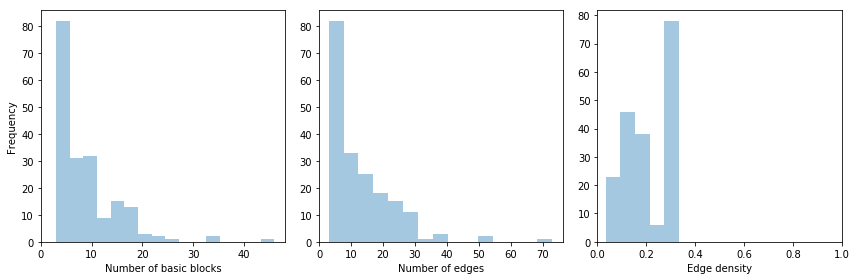

In [8]:
fig = plt.figure(figsize=(12, 4))
fig.clf()

ax = fig.add_subplot(1, 3, 1)
sns.distplot([g.number_of_nodes() for g in ocl_dataset_graphs], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of basic blocks')
ax.set_ylabel('Frequency')

ax = fig.add_subplot(1, 3, 2)
sns.distplot([g.number_of_edges() for g in ocl_dataset_graphs], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of edges')

edge_densities = [g.number_of_edges() / (g.number_of_nodes() * g.number_of_nodes()) 
                  for g in ocl_dataset_graphs]
ax = fig.add_subplot(1, 3, 3)
sns.distplot(edge_densities, kde=False, ax=ax)
ax.set_xlim((0, 1))
ax.set_xlabel('Edge density')

viz.finalise()

In [9]:
valid = [g.IsValidControlFlowGraph() for g in ocl_dataset_graphs]
print(f'{sum(valid)} of {len(valid)} ({sum(valid) / (len(valid) or 1):.1%}) graphs are valid')

98 of 191 (51.3%) graphs are valid


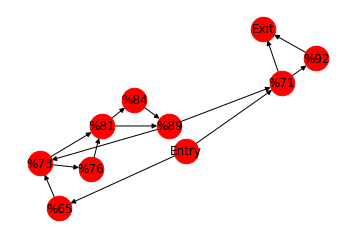

In [10]:
DrawGraph(ocl_dataset_graphs[0])

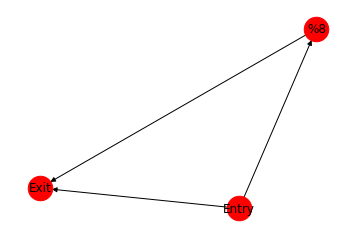

In [11]:
DrawGraph(ocl_dataset_graphs[6])

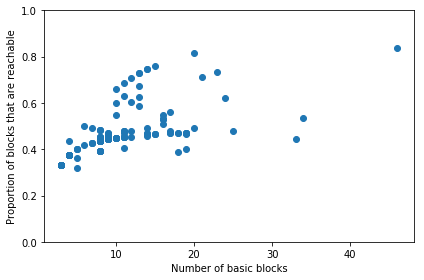

In [12]:
rows = []
for i, graph in enumerate(ocl_dataset_graphs):
    num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
    rows.append((graph.number_of_nodes(), num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

plt.scatter(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of basic blocks')
plt.ylabel('Proportion of blocks that are reachable')
plt.ylim((0, 1))
viz.finalise()

## Linux Dataset

In [13]:
linux_dataset = datasets.LinuxSourcesDataset()

linux_dataset_graphs = linux_dataset.cfgs_df['cfg:graph'].values

print(linux_dataset.cfgs_df.shape)
linux_dataset.cfgs_df.head(10)

(1848, 5)


,cfg:graph,cfg:block_count,cfg:edge_count,cfg:edge_density,cfg:is_valid
program:src_relpath,,,,,
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/async.c,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",42,42,0.053571,True
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/async.c,"(0, 1, 2, 3)",3,3,0.187500,False
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/async.c,"(0, 1, 2, 3, 4, 5, 6)",9,9,0.183673,True
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/async.c,"(0, 1, 2, 3, 4, 5, 6, 7)",9,9,0.140625,True
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/audit_fsnotify.c,"(0, 1, 2)",3,3,0.333333,True
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/audit_fsnotify.c,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",28,28,0.063492,False
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/audit_fsnotify.c,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)",15,15,0.123967,True
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/audit_fsnotify.c,"(0, 1, 2)",3,3,0.333333,True
/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/linux_srcs/kernel/audit_tree.c,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",31,31,0.077500,False


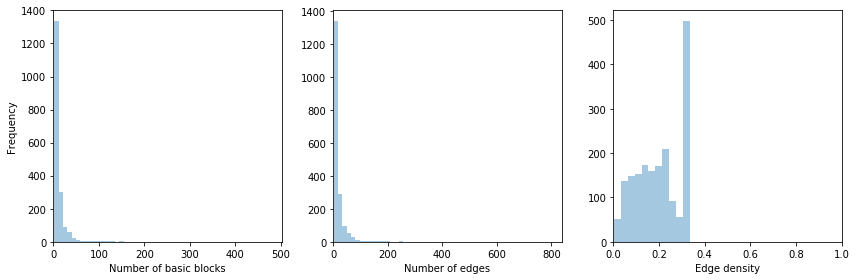

In [14]:
fig = plt.figure(figsize=(12, 4))
fig.clf()

ax = fig.add_subplot(1, 3, 1)
sns.distplot([g.number_of_nodes() for g in linux_dataset_graphs], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of basic blocks')
ax.set_ylabel('Frequency')

ax = fig.add_subplot(1, 3, 2)
sns.distplot([g.number_of_edges() for g in linux_dataset_graphs], kde=False, ax=ax)
ax.set_xlim((0, None))
ax.set_xlabel('Number of edges')

edge_densities = [g.number_of_edges() / (g.number_of_nodes() * g.number_of_nodes()) 
                  for g in linux_dataset_graphs]
ax = fig.add_subplot(1, 3, 3)
sns.distplot(edge_densities, kde=False, ax=ax)
ax.set_xlim((0, 1))
ax.set_xlabel('Edge density')

viz.finalise()

In [15]:
valid = [g.IsValidControlFlowGraph() for g in linux_dataset_graphs]
print(f'{sum(valid)} of {len(valid)} ({sum(valid) / (len(valid) or 1):.1%}) graphs are valid')

1366 of 1848 (73.9%) graphs are valid


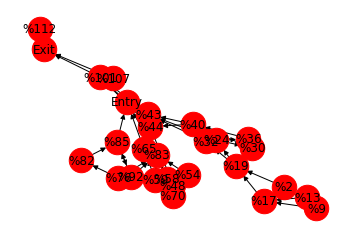

In [16]:
DrawGraph(linux_dataset_graphs[0])

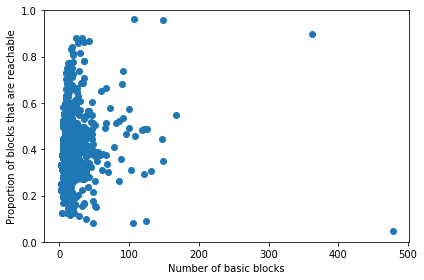

In [17]:
rows = []
for i, graph in enumerate(linux_dataset_graphs):
    num_reachable = sum(sum(graph.Reachables(node)) for node in graph.nodes)
    rows.append((graph.number_of_nodes(), num_reachable / (graph.number_of_nodes() * graph.number_of_nodes())))

df = pd.DataFrame(rows, columns=['num_nodes', 'reachability_density'])

plt.scatter(x='num_nodes', y='reachability_density', data=df)
plt.xlabel('Number of basic blocks')
plt.ylabel('Proportion of blocks that are reachable')
plt.ylim((0, 1))
viz.finalise()

## GraphNet model

### Define Features

Input graph features:
  node %3    [1. 0.]
  node %9    [0. 1.]
  node %12   [1. 0.]
  node %16   [1. 0.]
  node %57   [1. 0.]
  node %62   [1. 0.]
  node %69   [1. 0.]
  graph [0.]

Target graph features:
  node %3    [1. 0.]
  node %9    [1. 0.]
  node %12   [0. 1.]
  node %16   [0. 1.]
  node %57   [0. 1.]
  node %62   [0. 1.]
  node %69   [0. 1.]
  graph [0.]


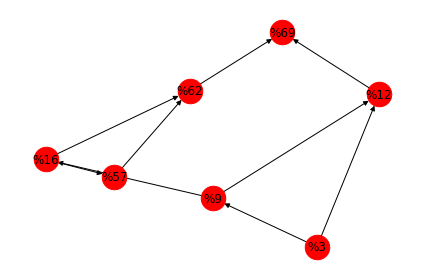

In [33]:
# Define graph features.

import collections
import typing

TargetGraphSpec = collections.namedtuple('TargetGraphSpec', ['graph', 'target_node_index'])

# Functions to generate feature vectors. Features vectors are np.arrays of floating point
# values.

def InputGraphNodeFeatures(spec: TargetGraphSpec, node_index: int) -> np.array:
    """Extract node features for an input graph."""
    node = spec.graph.nodes[node_index]
    # If the node is the target node, the features are [0, 1]. Else, the features are [1, 0].
    return np.array([
        0 if node_index == spec.target_node_index else 1,
        1 if node_index == spec.target_node_index else 0,
        # 1 if node.get('entry') else 0,
        # 1 if node.get('exit') else 0,
    ], dtype=float)

def InputGraphEdgeFeatures(spec: TargetGraphSpec, edge_index: typing.Tuple[int, int]):
    """Extract edge features for an input graph."""
    return np.ones(1, dtype=float)

def TargetGraphNodeFeatures(spec: TargetGraphSpec, node_index: int):
    """Extract node features for a target graph."""
    reachable = spec.graph.IsReachable(spec.target_node_index, node_index)
    return np.array([
        0 if reachable else 1,
        1 if reachable else 0,
    ], dtype=float)

def TargetGraphEdgeFeatures(spec: TargetGraphSpec, edge_index: typing.Tuple[int, int]):
    """Extract edge features for a target graph."""
    return np.ones(1, dtype=float)

def GraphToInputTarget(spec: TargetGraphSpec):
    """Produce two graphs with input and target feature vectors for training.
    
    A 'features' attributes is added node and edge data, which is a numpy array 
    of features describing the node or edge. The shape of arrays is consistent
    across input nodes, input edges, target nodes, and target edges.
    """
    input_graph = spec.graph.copy()
    target_graph = spec.graph.copy()
    
    # Set node features.
    for node_index in input_graph.nodes():
        input_graph.add_node(node_index, features=InputGraphNodeFeatures(spec, node_index))
        
    for node_index in target_graph.nodes():
        target_graph.add_node(node_index, features=TargetGraphNodeFeatures(spec, node_index))
        
    # Set edge features.
    for edge_index in input_graph.edges():
        input_graph.add_edge(*edge_index, features=InputGraphEdgeFeatures(spec, edge_index))
        
    for edge_index in target_graph.edges():
        target_graph.add_edge(*edge_index, features=TargetGraphEdgeFeatures(spec, edge_index))
    
    # Set global (graph) features.
    input_graph.graph['features'] = np.array([0.0])
    target_graph.graph['features'] = np.array([0.0])
    
    return input_graph, target_graph

graph, target_node_index = linux_dataset_graphs[2], 1
igraph, tgraph = GraphToInputTarget(TargetGraphSpec(
    graph=graph, target_node_index=target_node_index))

print('Input graph features:')
for node, data in igraph.nodes(data=True):
    print(f"  node {data['name']:5s} {data['features']}")
print(f'  graph {igraph.graph["features"]}')
print()
print('Target graph features:')
for node, data in tgraph.nodes(data=True):
    print(f"  node {data['name']:5s} {data['features']}")
print(f'  graph {tgraph.graph["features"]}')

DrawGraph(igraph, label_entry_and_exit=False)
viz.finalise()

In [19]:
from graph_nets import utils_tf as graph_net_utils_tf

def CreatePlaceholdersFromGraphs(graphs: typing.List[cfg.ControlFlowGraph], 
                                 batch_size: int):
    """Creates placeholders for the model training and evaluation.

    Args:
        graphs: A list of graphs that will be inspected for vector sizes.
        batch_size: Total number of graphs per batch.

    Returns:
        A tuple of the input graph's and target graph's placeholders, as a
        graph namedtuple.
    """
    input_graphs, target_graphs = zip(*[GraphToInputTarget(g) for g in graphs])
    
    input_ph = graph_net_utils_tf.placeholders_from_networkxs(
      input_graphs, force_dynamic_num_graphs=True)
    target_ph = graph_net_utils_tf.placeholders_from_networkxs(
      target_graphs, force_dynamic_num_graphs=True)
    return input_ph, target_ph

def PrintGraphTuple(gt):
    print('nodes', gt.nodes)
    print('edges', gt.edges)
    print('receivers', gt.receivers)
    print('senders', gt.senders)
    print('globals', gt.globals)
    print('n_node', gt.n_node)
    print('n_edge', gt.n_edge)
    
def MakeRunnableInSession(*args):
    """Lets an iterable of TF graphs be output from a session as NP graphs."""
    return [graph_net_utils_tf.make_runnable_in_session(a) for a in args]

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/pypi__h5py_2_7_1/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
def GetNumberOfMessagePassingSteps(specs) -> int:
    # TODO(cec): Determine the number of required message parsing steps.
    return 10

In [21]:
class SpecGenerator(object):
    
    def __init__(self, graphs: typing.Iterator[cfg.ControlFlowGraph]):
        self._graphs = graphs

    def Generate(self, n: int = 0):
        """Generate specs.
        
        Args:
            n: The maximum number of spec to generatte. If zero, enumerate
                all graphs.
        """
        i = 0
        for g in self._graphs:
            for nn in range(g.number_of_nodes()):
                i += 1
                if n and i >= n:
                    return
                yield TargetGraphSpec(graph=g, target_node_index=nn)

In [22]:
def CreateLossOps(target_op, output_ops):
    return [
        tf.losses.softmax_cross_entropy(target_op.nodes, output_op.nodes) +
        tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges)
        for output_op in output_ops
    ]

### Define Model

In [23]:
# Define model.
from graph_nets.demos import models
import tensorflow as tf

tf.reset_default_graph()

seed = 0

# Data / training parameters.
num_training_iterations = 5000
batch_size_tr = 32
batch_size_ge = 100
edge_density_tr = .1
edge_density_ge = .1
# Number of nodes per graph sampled uniformly from this range.
num_nodes_min_max_tr = (5, 20)
num_nodes_min_max_ge = (15, 25)

graph_generator_tr = cfg_generator.ControlFlowGraphGenerator(
    np.random.RandomState(seed), num_nodes_min_max_tr, edge_density_tr)
spec_generator_tr = SpecGenerator(graph_generator_tr)

# Data.
# Input and target placeholders.
graphs_tr = spec_generator_tr.Generate(num_training_iterations)

input_ph, target_ph = CreatePlaceholdersFromGraphs(graphs_tr, batch_size_tr)

num_processing_steps_tr = GetNumberOfMessagePassingSteps(graphs_tr)
# TODO: We haven't generated evaluation graphs yet, so we calculate the
# number of message passing steps from the training graphs.
num_processing_steps_ge = GetNumberOfMessagePassingSteps(graphs_tr)

# Connect the data to the model.
# Instantiate the model.
# TODO: What is the edge output and node output size exactly?
model = models.EncodeProcessDecode(edge_output_size=1, node_output_size=2)
# A list of outputs, one per processing step.
output_ops_tr = model(input_ph, num_processing_steps_tr)
output_ops_ge = model(input_ph, num_processing_steps_ge)

# Training loss.
loss_ops_tr = CreateLossOps(target_ph, output_ops_tr)
# Loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss.
loss_ops_ge = CreateLossOps(target_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.

# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

# Lets an iterable of TF graphs be output from a session as NP graphs.
input_ph, target_ph = MakeRunnableInSession(input_ph, target_ph)

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/experimental/compilers/reachability/notebooks/notebooks.runfiles/pypi__tensorflow_gpu_1_8_0/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Reset Session

In [24]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [25]:
from graph_nets import utils_np as graph_net_utils_np

def CreateFeedDict(graphs: typing.List[cfg.ControlFlowGraph], 
                   input_ph, target_ph):
    """Creates placeholders for the model training and evaluation.

    Args:
        graphs: A list of graphs that will be inspected for vector sizes.
            batch_size: Total number of graphs per batch.
        input_ph: The input graph's placeholders, as a graph namedtuple.
        target_ph: The target graph's placeholders, as a graph namedtuple.

    Returns:
        feed_dict: The feed `dict` of input and target placeholders and data.
        raw_graphs: The `dict` of raw networkx graphs.
    """
    graphs = list(graphs)
    input_graphs, target_graphs = zip(*[GraphToInputTarget(g) for g in graphs])
    
    input_graphs = graph_net_utils_np.networkxs_to_graphs_tuple(input_graphs)
    target_graphs = graph_net_utils_np.networkxs_to_graphs_tuple(target_graphs)
    feed_dict = {input_ph: input_graphs, target_ph: target_graphs}
    return feed_dict, graphs

In [26]:
def ComputeAccuracy(target, output):
    """Calculate model accuracy.

    Returns the number of correctly labelled nodes/edges and the number
    of completely solved graphs (100% correct labels).

    Args:
        target: A `graphs.GraphsTuple` that contains the target graph.
        output: A `graphs.GraphsTuple` that contains the output graph.

    Returns:
        correct: A `float` fraction of correctly labeled nodes/edges.
        solved: A `float` fraction of graphs that are completely correctly labeled.

    Raises:
        ValueError: Nodes or edges (or both) must be used
    """
    tdds = graph_net_utils_np.graphs_tuple_to_data_dicts(target)
    odds = graph_net_utils_np.graphs_tuple_to_data_dicts(output)
    cs = []
    ss = []
    for td, od in zip(tdds, odds):
        # TODO: We are ignoring edge values.
        xn = np.argmax(td["nodes"], axis=-1)
        yn = np.argmax(od["nodes"], axis=-1)
        c = [xn == yn]
        c = np.concatenate(c, axis=0)
        s = np.all(c)
        cs.append(c)
        ss.append(s)
    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(np.stack(ss))
    return correct, solved

### Run training

In [ ]:
# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# How much time between logging and printing the current results.
log_every_seconds = 10

print(f'Beginning {humanize.intcomma(num_training_iterations)} training iterations')
print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    seed += 1
    last_iteration = iteration
    data_generator = SpecGenerator(cfg_generator.ControlFlowGraphGenerator(
        np.random.RandomState(seed), num_nodes_min_max_tr, edge_density_tr))
    feed_dict, _ = CreateFeedDict(data_generator.Generate(batch_size_tr), input_ph, target_ph)
    train_values = sess.run({
        "step": step_op,
        "target": target_ph,
        "loss": loss_op_tr,
        "outputs": output_ops_tr
    }, feed_dict=feed_dict)
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        data_generator = SpecGenerator(cfg_generator.ControlFlowGraphGenerator(
            np.random.RandomState(seed + 1), num_nodes_min_max_ge, edge_density_ge))
        feed_dict, _ = CreateFeedDict(
            data_generator.Generate(batch_size_ge), input_ph, target_ph)
        test_values = sess.run({
            "target": target_ph,
            "loss": loss_op_ge,
            "outputs": output_ops_ge
        }, feed_dict=feed_dict)
        correct_tr, solved_tr = ComputeAccuracy(
            train_values["target"], train_values["outputs"][-1])
        correct_ge, solved_ge = ComputeAccuracy(
            test_values["target"], test_values["outputs"][-1])
        elapsed = time.time() - start_time
        losses_tr.append(train_values["loss"])
        corrects_tr.append(correct_tr)
        solveds_tr.append(solved_tr)
        losses_ge.append(test_values["loss"])
        corrects_ge.append(correct_ge)
        solveds_ge.append(solved_ge)
        logged_iterations.append(iteration)
        print(f'# {humanize.intcomma(iteration)}, T {humanize.naturaldelta(elapsed)}, '
              f'Ltr {train_values["loss"]:.4f}, Lge {test_values["loss"]:.4f}, '
              f'Ctr {correct_tr:.4f}, Str {solved_tr:.4f}, '
              f'Cge {correct_ge:.4f}, Sge {solved_ge:.4f}')

Beginning 5,000 training iterations
# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)
# 16, T 11 seconds, Ltr 0.6014, Lge 0.5835, Ctr 0.7232, Str 0.4516, Cge 0.7554, Sge 0.5354
# 73, T 20 seconds, Ltr 0.4549, Lge 0.5151, Ctr 0.8059, Str 0.0968, Cge 0.6876, Sge 0.0505
# 134, T 30 seconds, Ltr 0.3991, Lge 0.4800, Ctr 0.8207, Str 0.7097, Cge 0.7346, Sge 0.2626
# 191, T 40 seconds, Ltr 0.3296, Lge 0.4680, Ctr 0.8380, Str 0.5161, Cge 0.8087, Sge 0.0808
# 253, T 50 seconds, Ltr 0.2488, Lge 0.0830, Ctr 1.0000, Str 1.0000, Cge 0.9907, Sge 0.9596
# 313, T a minute, Ltr 0.2094, Lge 0.0881, Ctr 1.0000, Str 1.0000, Cge 0.9964, Sge 0.9293
# 374, T a minute, Ltr 0.2082, Lge 0.0208, Ctr 1.0000, Str 1.0000, Cge 1.0000, Sge 1.0000
# 4

### Visualize Training

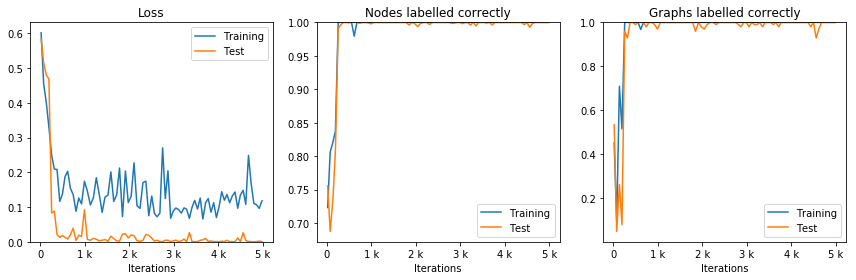

In [37]:
from matplotlib.ticker import EngFormatter

fig = plt.figure(figsize=(12, 4))
fig.clf()

ax = fig.add_subplot(1, 3, 1)
ax.plot(logged_iterations, losses_tr, label='Training')
ax.plot(logged_iterations, losses_ge, label='Test')
ax.xaxis.set_major_formatter(EngFormatter(places=0))
# ax.set_ylabel('Loss')
ax.set_ylim((0, None))
ax.set_xlabel('Iterations')
ax.set_title('Loss')
ax.legend(loc='upper right')

ax = fig.add_subplot(1, 3, 2)
ax.plot(logged_iterations, corrects_tr, label='Training')
ax.plot(logged_iterations, corrects_ge, label='Test')
ax.xaxis.set_major_formatter(EngFormatter(places=0))
ax.set_ylim((None, 1))
ax.set_xlabel('Iterations')
ax.set_title('Nodes labelled correctly')
ax.legend(loc='lower right')

ax = fig.add_subplot(1, 3, 3)
ax.plot(logged_iterations, solveds_tr, label='Training')
ax.plot(logged_iterations, solveds_ge, label='Test')
ax.xaxis.set_major_formatter(EngFormatter(places=0))
ax.set_ylim((None, 1))
ax.set_xlabel('Iterations')
ax.set_title('Graphs labelled correctly')
ax.legend(loc='lower right')

viz.finalise()

### Test on OpenCL Graphs

In [35]:
from labm8 import decorators

class ReachabilityModelEvaluator(object):
    
    def __init__(self, specs: typing.List[TargetGraphSpec], predicted_reachabilities: typing.List[np.array],
                 data = None):
        self._specs = specs
        self._predicted_reachabilities = predicted_reachabilities
        self.data = data or {}
        if len(self._specs) != len(self._predicted_reachabilities):
            raise ValueError

    @decorators.memoized_property
    def _correct_solved(self):
        cs = []
        ss = []
        for spec, predicted in zip(self._specs, self._predicted_reachabilities):
            reachables = [spec.graph.IsReachable(spec.target_node_index, node_index) for node_index in spec.graph.node]
            if len(predicted) != len(reachables):
                raise ValueError
            c = [reachables == predicted]
            c = np.concatenate(c, axis=0)
            s = np.all(c)
            cs.append(c)
            ss.append(s)
        correct = np.mean(np.concatenate(cs, axis=0))
        solved = np.mean(np.stack(ss))
        return correct, solved
    
    @property
    def correct_nodes(self):
        return self._correct_solved[0]
    
    @property
    def correct_graphs(self):
        return self._correct_solved[1]
    
    def ToDict(self):
        data = self.data.copy()
        data.update({
            'correct_nodes': self.correct_nodes,
            'correct_graphs': self.correct_graphs
        })
        return data

generator_test = SpecGenerator(ocl_dataset.cfgs_df['cfg:graph'].values)
feed_dict, ocl_graphs = CreateFeedDict(
    generator_test.Generate(), input_ph, target_ph)
ocl_values = sess.run({
    "target": target_ph,
    "loss": loss_op_ge,
    "outputs": output_ops_ge
}, feed_dict=feed_dict)

r = ReachabilityModelEvaluator(
    ocl_graphs,
    [np.argmax(d['nodes'], axis=-1) for d in graph_net_utils_np.graphs_tuple_to_data_dicts(ocl_values["outputs"][-1])],
    {'name': 'OpenCL'})
print(r.ToDict())

{'name': 'OpenCL', 'correct_nodes': 0.9671795784043404, 'correct_graphs': 0.8739445114595898}


In [40]:
ones_r = ReachabilityModelEvaluator(
    ocl_graphs,
    [np.ones(s.graph.number_of_nodes()) for s in ocl_graphs], {'rule': 'Always reachable'})
zeros_r = ReachabilityModelEvaluator(
    ocl_graphs,
    [np.zeros(s.graph.number_of_nodes()) for s in ocl_graphs], {'rule': 'Never reachable'})

zero_r = max(ones_r, zeros_r, key=lambda r: r.correct_nodes)
zero_r.ToDict()

{'rule': 'Always reachable',
 'correct_nodes': 0.542470870764031,
 'correct_graphs': 0.0}

### Linux Graphs

In [38]:
generator_test = SpecGenerator(linux_dataset.cfgs_df['cfg:graph'].values)
# Only the first 1000 graphs
feed_dict, linux_graphs = CreateFeedDict(
    generator_test.Generate(1000), input_ph, target_ph)
linux_values = sess.run({
    "target": target_ph,
    "loss": loss_op_ge,
    "outputs": output_ops_ge
}, feed_dict=feed_dict)

r = ReachabilityModelEvaluator(
    linux_graphs,
    [np.argmax(d['nodes'], axis=-1) for d in graph_net_utils_np.graphs_tuple_to_data_dicts(linux_values["outputs"][-1])],
    {'name': 'Linux'})
print(r.ToDict())

{'name': 'Linux', 'correct_nodes': 0.8149358066432129, 'correct_graphs': 0.6976976976976977}


In [41]:
ones_r = ReachabilityModelEvaluator(
    linux_graphs,
    [np.ones(s.graph.number_of_nodes()) for s in linux_graphs], {'rule': 'Always reachable'})
zeros_r = ReachabilityModelEvaluator(
    linux_graphs,
    [np.zeros(s.graph.number_of_nodes()) for s in linux_graphs], {'rule': 'Never reachable'})

zero_r = max(ones_r, zeros_r, key=lambda r: r.correct_nodes)
zero_r.ToDict()

{'rule': 'Never reachable',
 'correct_nodes': 0.6032804861333212,
 'correct_graphs': 0.07307307307307308}